# Input Dimensions
From the .cdf files, data is stored in the following units <br>

| Parameter| Unit   |
|------|------|
|   Water Content | g/m3|
| Height|m|
|Velocity|m/s|
|Spectral width|m/s|
|Reflectivity|dBZ|
|Extinction|1/km|
|Temperature|C|
|CCN|1/cm3|


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('C:/Users/yashg/Documents/Cloud_Data_Files/')
from IPython.display import display, Image

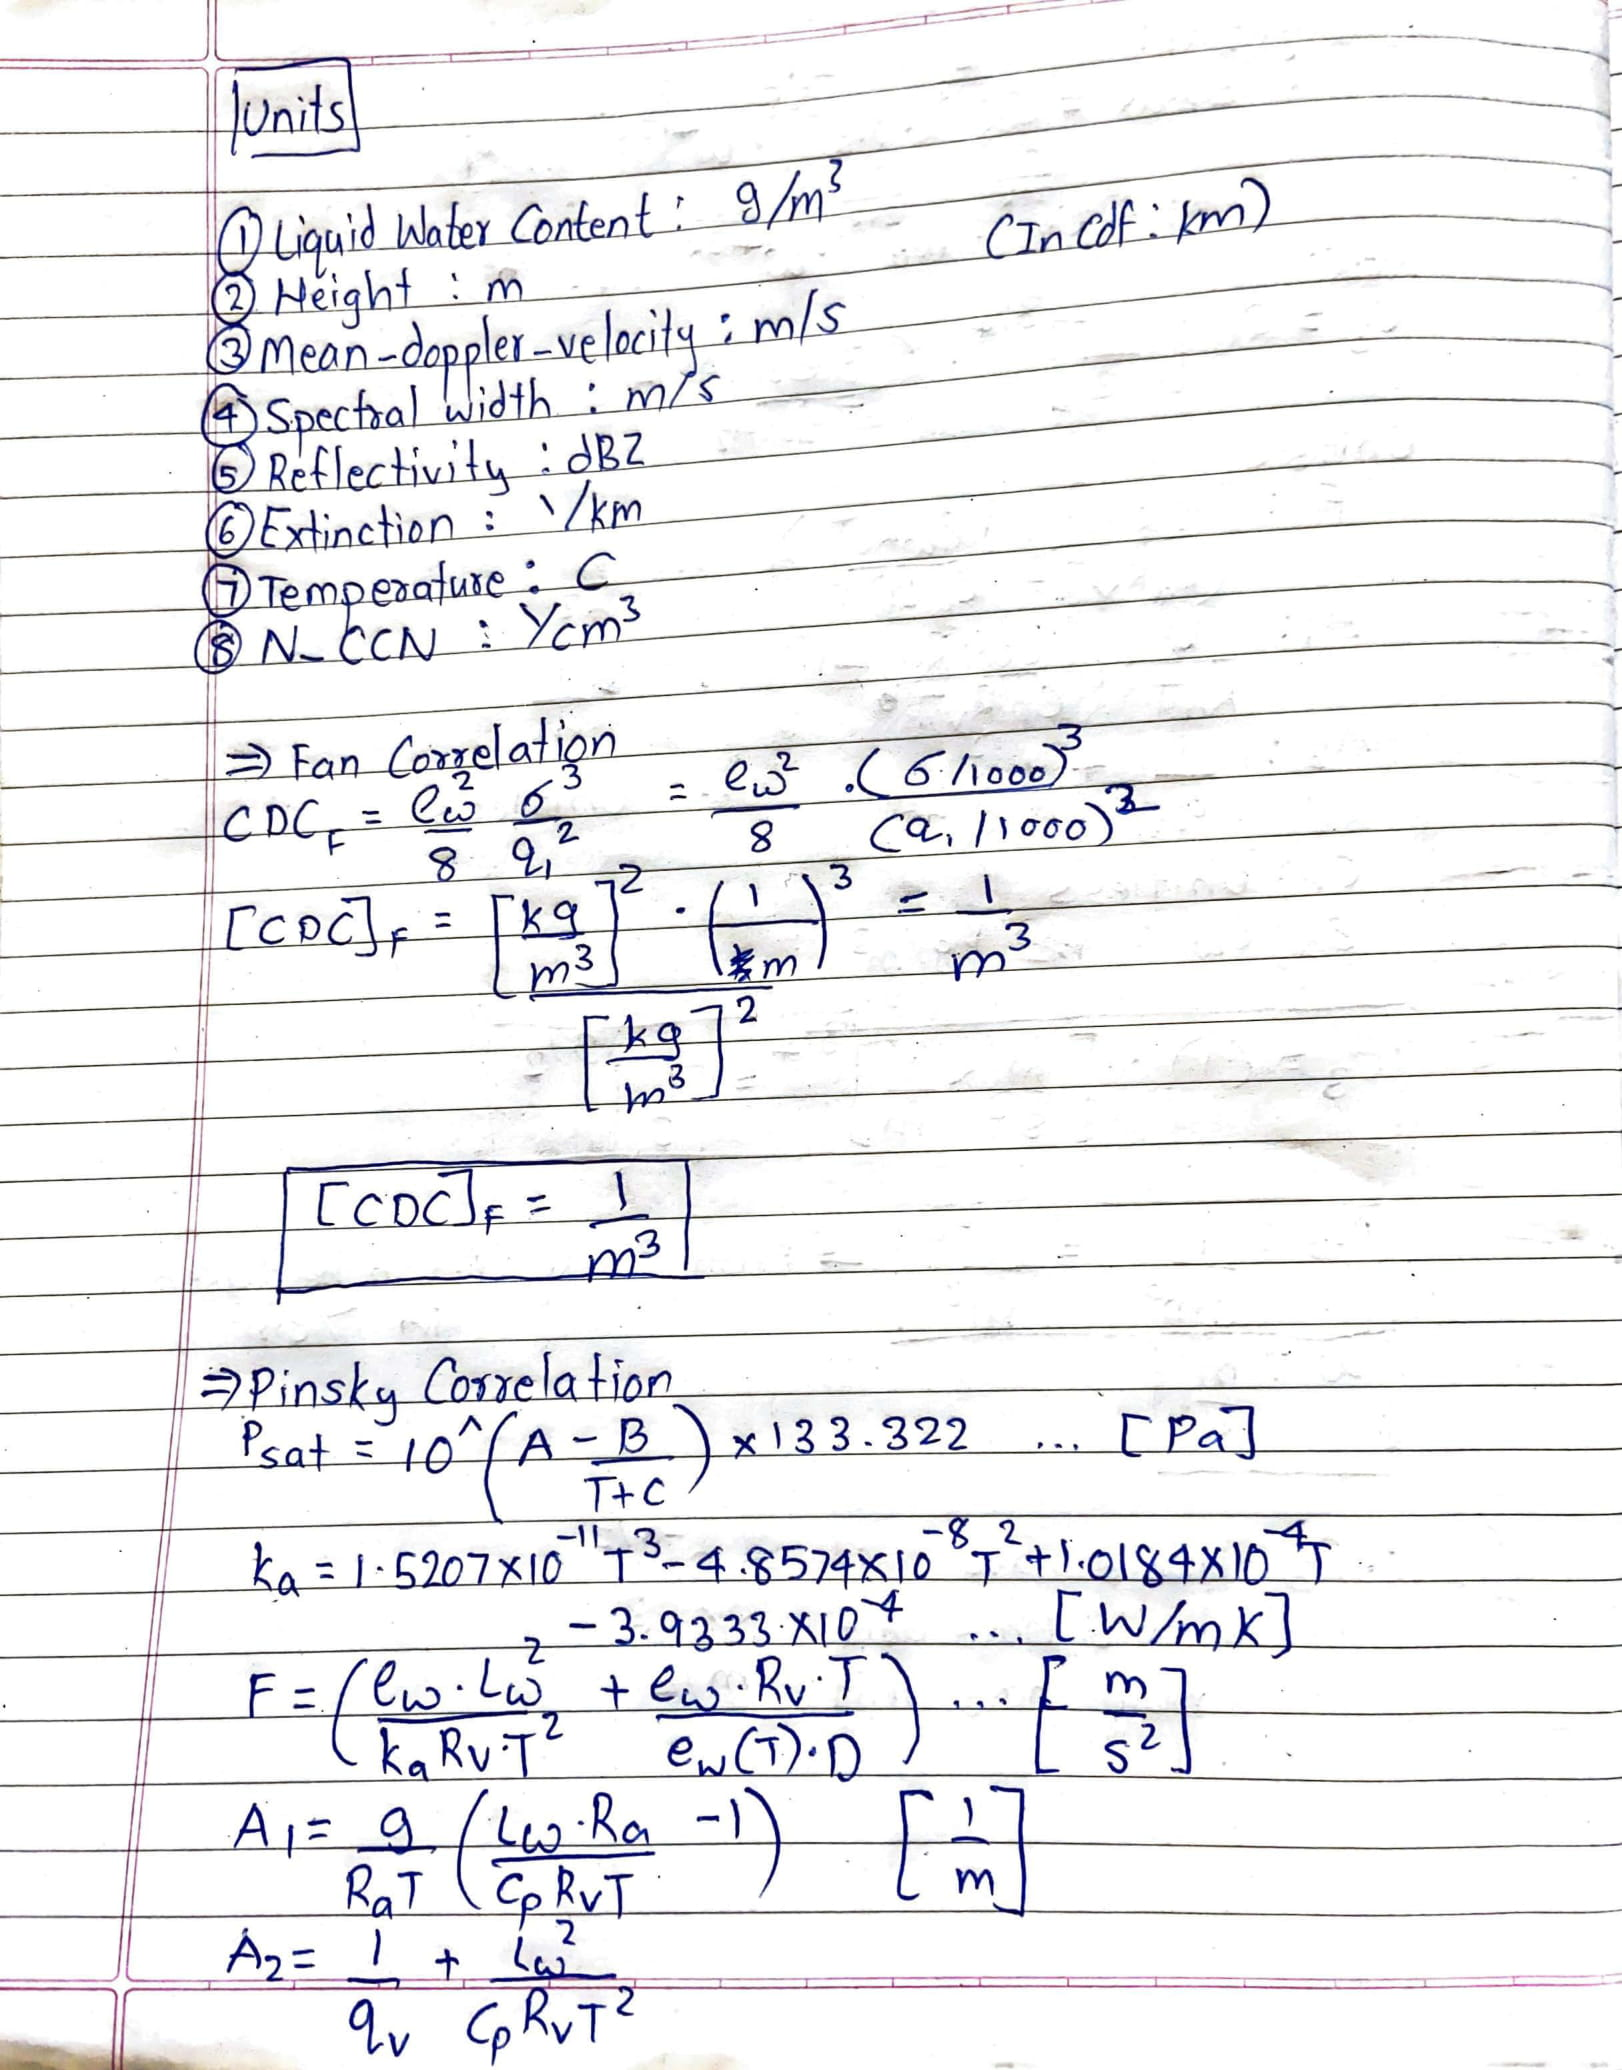

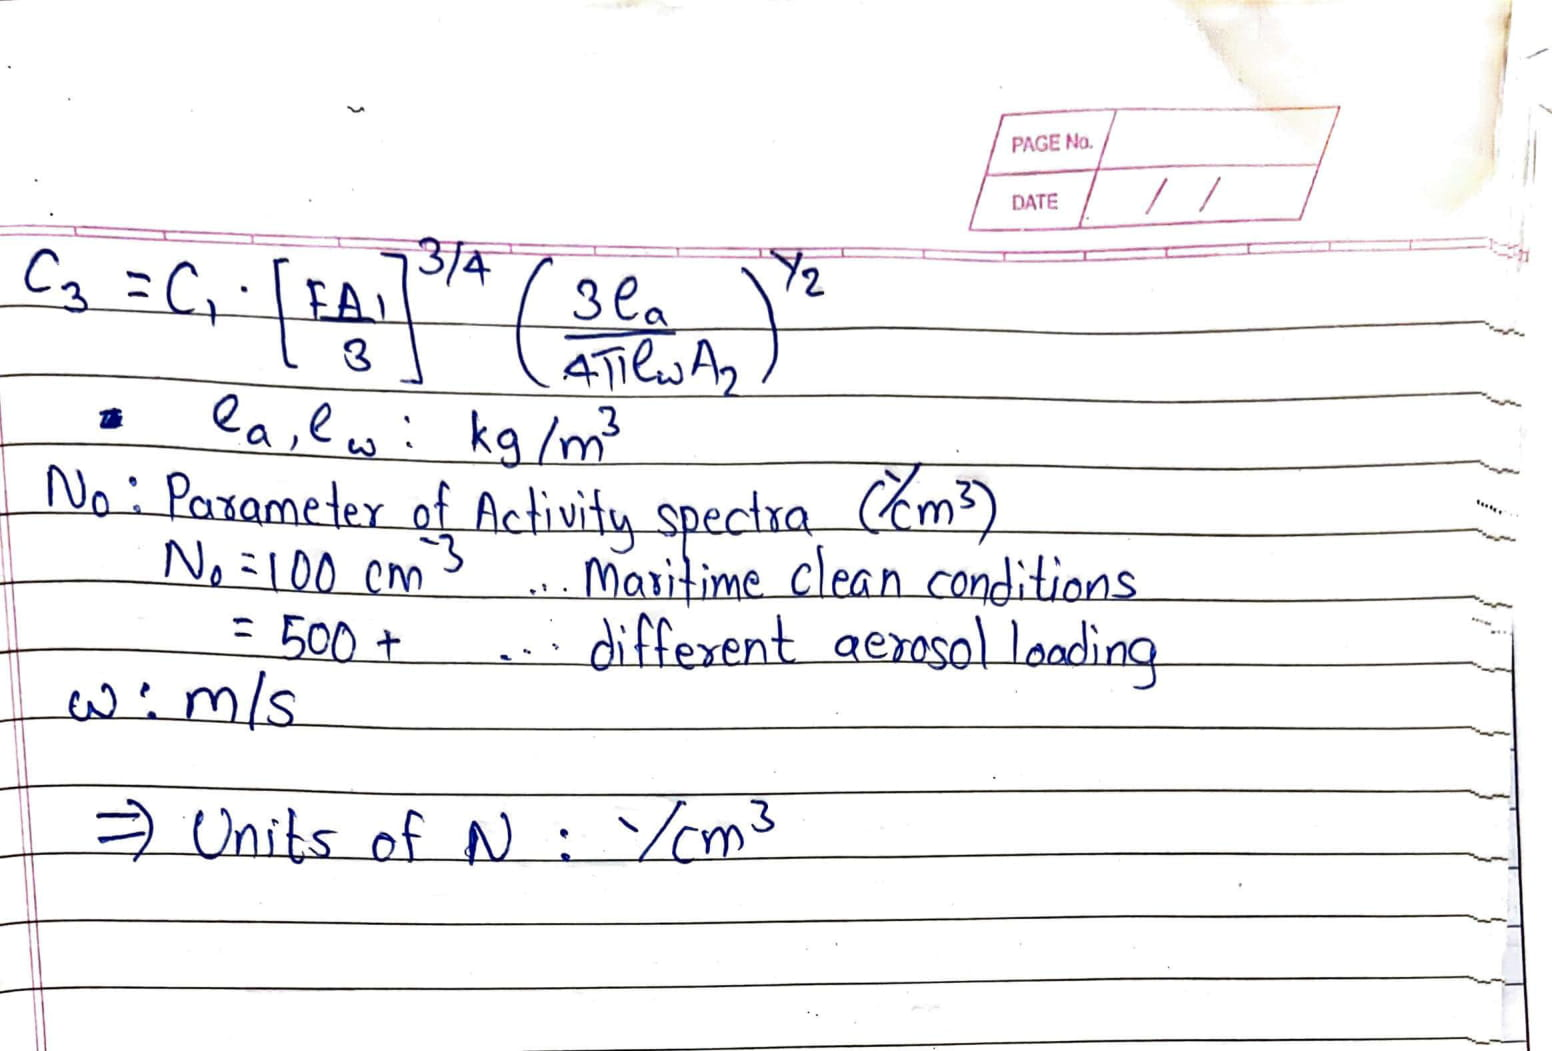

In [16]:
display(Image(filename='p1.png'))
display(Image(filename='p2.jpg'))

# Parameters 
(All Values in SI Units)

In [3]:
A=8.07131
B=1730.63
C=233.426
l=2260000 #J/kg
a_cond=0.022 #W/m/K
a_water=5.5575 #W/m/K
D=0.242*10**-4 #m^2/s
Ra=287 #J/deg/kg
Rv=461 #J/deg/kg
qv=0.038 #kg/kg
rhow=1000 #kg/m3
rhoa=1.225 #kg/m3
g=9.8 #m2/s
cp=1000 #J/kg
C1=1.058 

In [4]:
data=pd.read_csv('filtered_data.csv')
temp=data['Temperature']
data['T(K)']=temp+273.16
temp=data['T(K)']
lwc=data['LWC']
v=data['Mean_Doppler_Velocity']
ex=data['Extinction']
ccn=data['CCN']

# Pinksy Correlation
Calculating CDC and Maximum Saturation through Pinksy et al. correlation
Value of k is varied from 0.3-1.0

In [5]:
def vaporpressure(temp):
    p=10**(A-(B)/(C+temp))
    p=p*133.322
    return p #in pascals

def constants(temp):
    vp=vaporpressure(temp-273.15)
    k=(1.52E-11)*(temp)**3-(4.8574E-8)*(temp)**2+1.0184E-04*(temp)-3.9333E-04
    F=(rhow*(l)**2/k/Rv/(temp)**2)+(rhow*Rv*(temp)/vp/D)
    A1=(g/Ra/temp*((l*Ra/(cp*Rv*temp))-1))
    A2=1/qv+((l)**2/cp/Rv/(temp)**2)
    return k,F,A1,A2

def C3(temp):
    k,F,A1,A2=constants(temp)
    a=C1*(F*A1/3)**0.75
    b=(3*rhoa/4/np.pi/rhow/A2)**0.5
    return a*b

def CDC_pinsky(temp,No,v,k):
    C=C3(temp)
    a=C**(2*k/(2+k))
    b=No**(2/(2+k))
    c=np.abs(v)**(3*k/(4+2*k))
    return a*b*c

def Smax(temp,No,v,k):
    C=C3(temp)
    a=C**(2/(2+k))
    b=No**(-1/(2+k))
    c=np.abs(v)**(3/(4+2*k))
    return a*b*c 

In [6]:
slope=[0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for m in slope:
    data[f'CDC_pinsky,k={m}']=CDC_pinsky(temp,ccn,v,m)
    data[f'Smax,k={m}']=Smax(temp,ccn,v,m)

# Fan Correlation

In [7]:
def CDC_Fan(ext,lwc):
    x=rhow**2*(ext/1000)**(3)/8/(lwc/1000)**2
    return x/10**6

In [8]:
cdcf=CDC_Fan(ex,lwc)
data['CDC_Fan']=cdcf

# Visualizing the Results

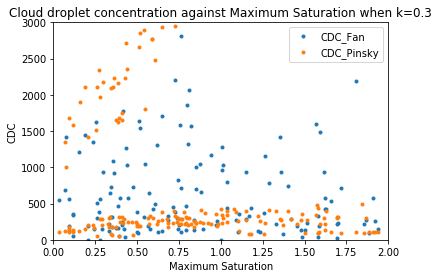

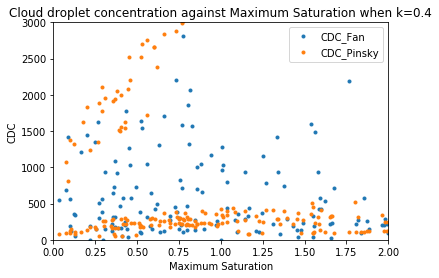

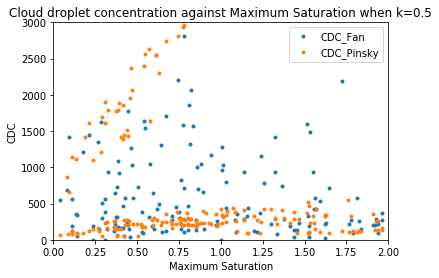

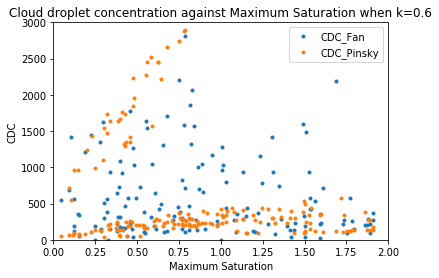

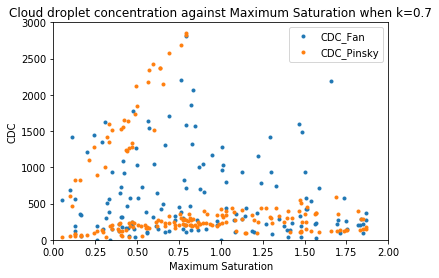

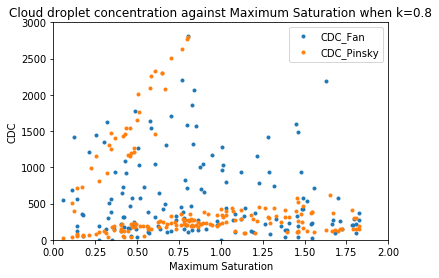

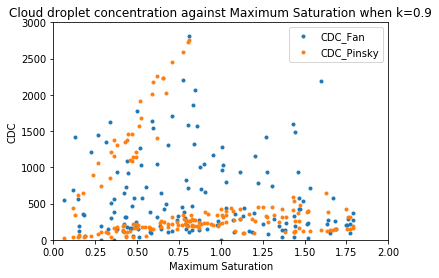

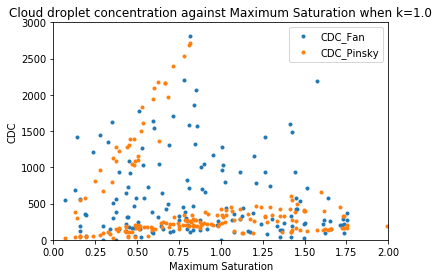

In [9]:
def comparison(k):
    plt.plot(data[f'Smax,k={k}'],cdcf,'.',label='CDC_Fan')
    plt.plot(data[f'Smax,k={k}'],data[f'CDC_pinsky,k={k}'],'.',label='CDC_Pinsky')
    plt.xlabel('Maximum Saturation')
    plt.ylabel('CDC')
    plt.title(f'Cloud droplet concentration against Maximum Saturation when k={k}')
    plt.ylim(0,3000)
    plt.xlim(0,2)
    plt.legend()
    plt.savefig(f'C:/Users/yashg/OneDrive/Desktop/CMU/Project/Plots/cdc_smax/cdc_{k}.png')
    plt.show()
for s in slope:
    comparison(s)

# Optimizing

In [10]:
#Choosing best k
from scipy.optimize import curve_fit
def f(x,slope):
    t,n,v=x
    y=CDC_pinsky(t,n,v,slope)
    return y

In [11]:
xdata=[temp,ccn,v]
ydata=cdcf
args=np.argwhere((xdata==xdata) & (ydata==ydata) &(xdata!=np.inf)&(ydata!=np.inf)&(ydata<=3000))
args = [item for sublist in args for item in sublist]
xdata=[temp[args],ccn[args],v[args]]
ydata=ydata[args]
pars,pcov=curve_fit(f,xdata,ydata,bounds=(0,1))
print(f'Fitted value of k for least error is {pars[0]}')

Fitted value of k for least error is 0.9999999999999999


C:\Users\yashg\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


# Writing the file

In [12]:
data.to_csv('C:/Users/yashg/Documents/Cloud_Data_Files/CDC_calculations.csv')